In [72]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray
from os import path
from sklearn.ensemble import IsolationForest

In [73]:
dirname = os.path.abspath(os.curdir) + r'\data'
lake_ds = pd.read_csv(path.join(os.sep, dirname, 'dataset.csv')) # Читаем .csv файл, в которо содержаьтся данные с годовым количеством осадков в озере Верхнее с 1900 по 1986 год
# lake_ds.set_index('Year').sort_index()
df = lake_ds.copy()

In [74]:
df.head()

,Year,x
0,1,28.55
1,2,27.37
2,3,25.60
3,4,29.93
4,5,27.61


## Предсказание временного ряда при помощи Random forecast

In [75]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [76]:
len(list_for_forecast)

86

In [77]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [78]:
predictions = list()
size = int(len(list_for_forecast) * 0.8)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  3.3258077777778174


In [79]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 4.4975187080136685
MAPE: 0.10466232528034046
MAE: 3.3258077777778174
R2:  -0.25422806026936895


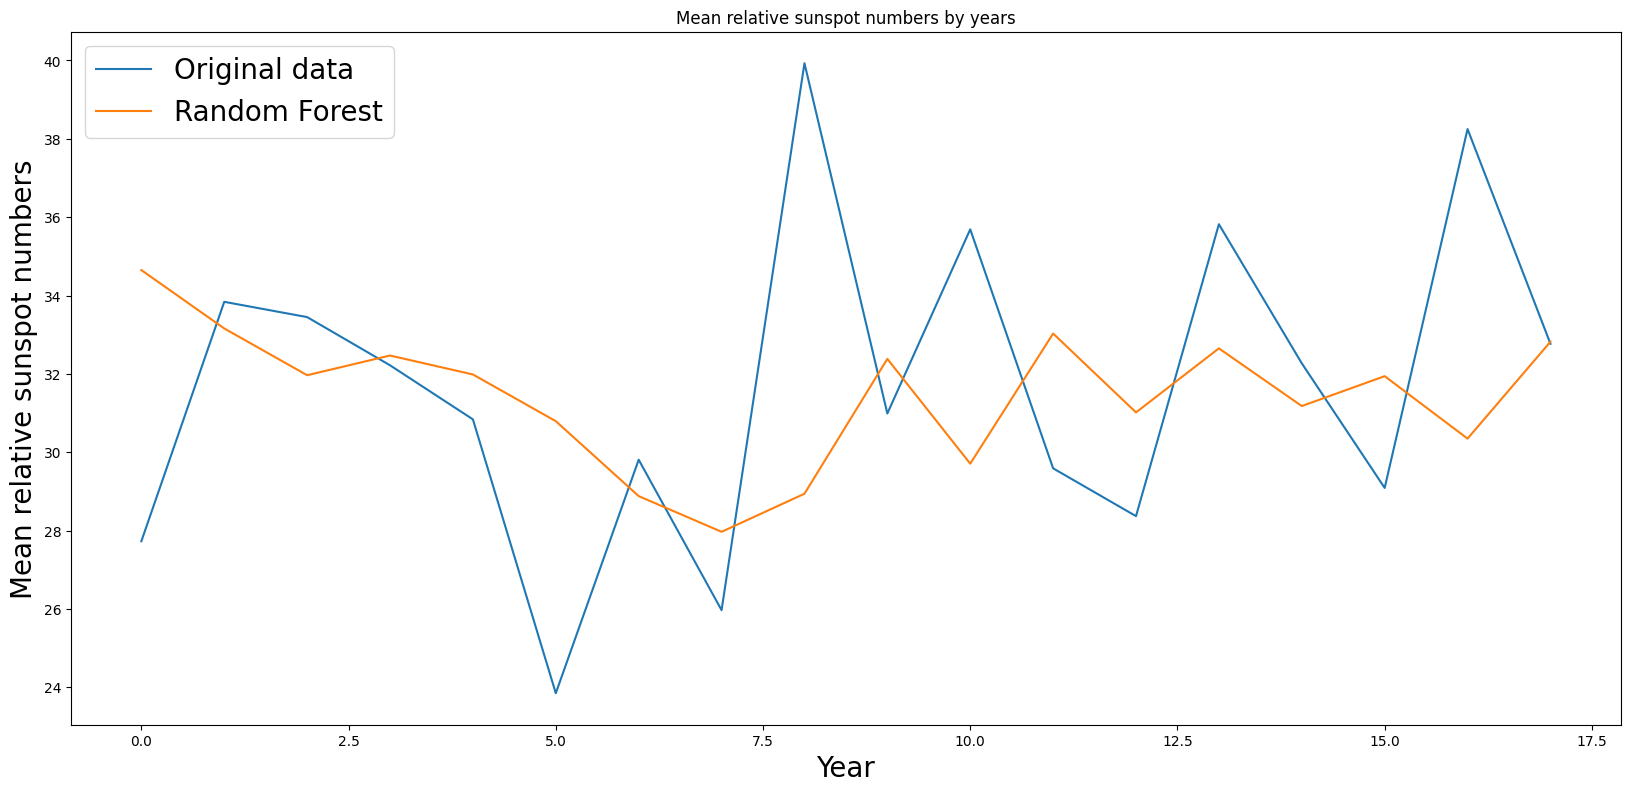

In [83]:
fig = plt.figure(figsize=(20, 9))
# plt.plot(df['x'], label='Original data')
# plt.plot([None for i in range(len(df['x'])-len(predictions))] + predictions, label='Random Forest')
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Mean relative sunspot numbers by years')
plt.ylabel('Mean relative sunspot numbers', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [84]:
model = IsolationForest(contamination=0.004)
model.fit(df[['x']])

IsolationForest(contamination=0.004)

In [85]:
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [86]:
df.query('outliers=="yes"')

,Year,x,outliers
77,78,39.93,yes


In [89]:
fig = px.scatter(df.reset_index(), x='index', y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()